In [3]:
import os
import sys
import torch
import collections

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)
from FLTrack.models import ShallowNN
from FLTrack.evals import evaluate 
from FLTrack.eccentricity import pairwise_euclidean_distance, layerwise_proximity, layerwise_eccentricity

features = 197
batch_size = 64
loss_fn = torch.nn.L1Loss()

In [4]:
client_ids = [f"c{i}" for i in range(1, 25)]

In [8]:
dummy = torch.load("../FLTrack/checkpt/fedl/epoch_250/25_rounds_10_epochs_per_round/global_model.pth")
critarians = [item for item in dummy]

In [10]:
critarians = ['layer_1.weight','layer_1.bias',
'bn_1.weight',
'bn_1.bias',
'layer_2.weight',
'layer_2.bias',
'layer_3.weight','layer_3.bias']

### Calculating eccentricities in each iteration with $\xi^P$


In [11]:
df_dict = {}
for iter in range(1,26):
    
    state_dicts = {
        key: torch.load("../FLTrack/checkpt/fedl/epoch_250/25_rounds_10_epochs_per_round/global_" + str(iter) + "/clients/client_model_" + str(key) + ".pth")
        for key in client_ids
    }    
    
    layer_prox = {}
    for cri in critarians:
        layer_prox[cri] = layerwise_eccentricity(state_dicts,cri,pairwise_euclidean_distance)
    
    round_frame = pd.DataFrame.from_dict(layer_prox, orient='index')
    round_frame = round_frame.T.reset_index().rename(columns={"index":"client_id"})
    
    averages = [] 
    for index, client in round_frame.iterrows():
        avg = (client['layer_1.weight'] + client['layer_1.bias'] + client['layer_2.weight'] + client['layer_2.bias'] + client['layer_3.weight'] + client['layer_3.bias'])/6
        averages.append(round(avg,4))
    round_frame["average_weight"] = averages
    
    df_dict[iter] = round_frame

### Taking eccentricities of each client into a dict

In [14]:
ecc_dict = {}
for client in client_ids:   
    client_ecc = []
    for iter in range(1,26):
        client_ecc.append(df_dict[iter][df_dict[iter]['client_id'] == client].average_weight.values.item())
        ecc_dict[client] = client_ecc

In [15]:
dataframe = pd.DataFrame(ecc_dict).T.reset_index().rename(columns={"index": "client_id"})
dataframe['average_parameter_ecc'] = dataframe.apply( lambda row: round(row.drop('client_id').mean(),4), axis=1)

In [16]:
#dataframe.to_csv("insights/parameter_based_eccentricities_allrounds.csv", index=False)

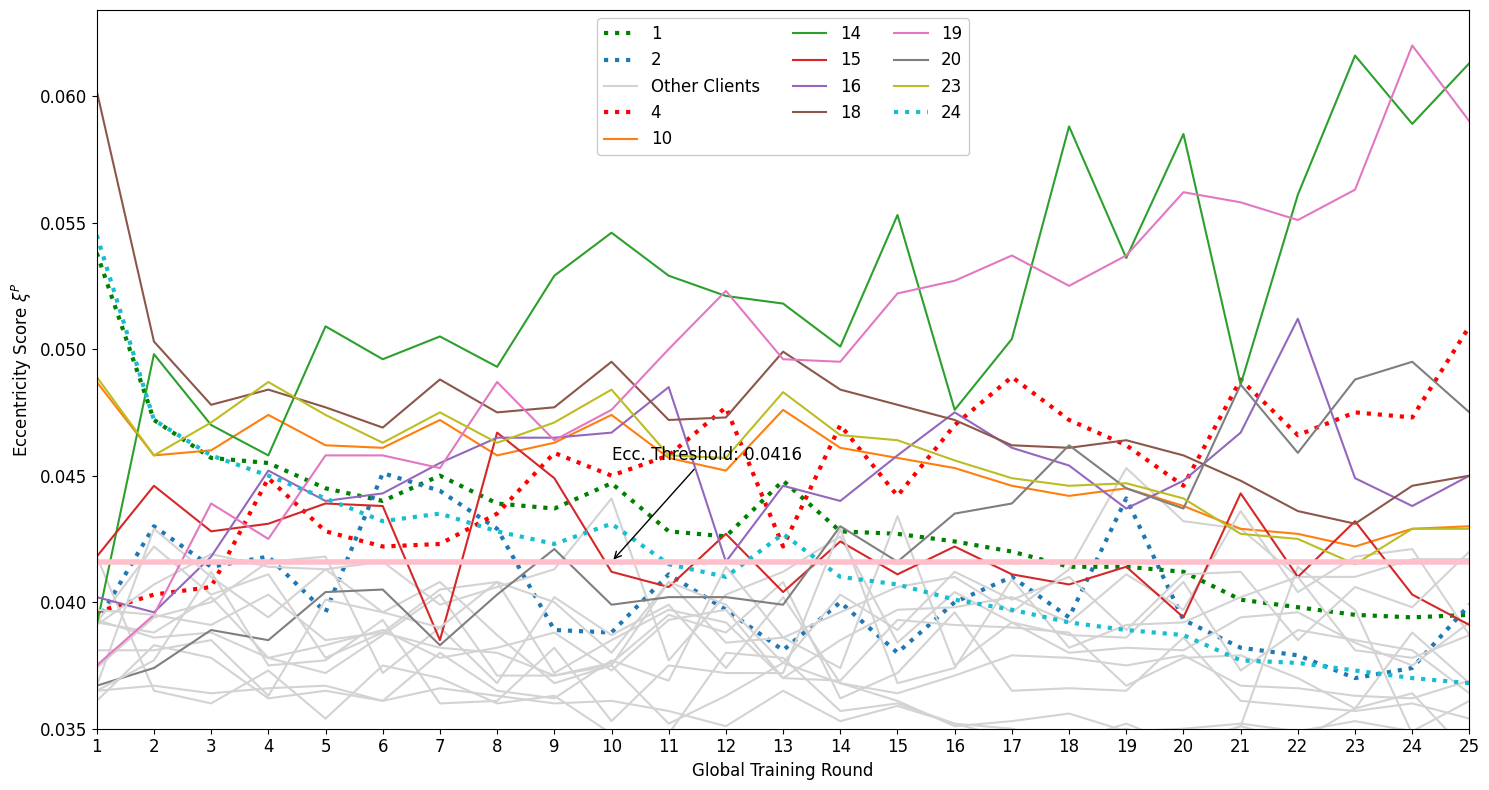

In [17]:
x_values = list(range(1, 26))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(ecc_dict.items()):
    if i+1 in [10,14,15,16,18,19,20,23]:
        plt.plot(x_values, values, label=str(i + 1))
    elif i+1 in [4]:
        plt.plot(x_values, values,color='red', label=str(i + 1), linestyle='dotted',linewidth=3)
    elif i+1 in [1]:
        plt.plot(x_values, values, color='green', label=str(i + 1), linestyle='dotted',linewidth=3)
    elif i+1 in [2,24]:
        plt.plot(x_values, values, label=str(i + 1), linestyle='dotted',linewidth=3)
    else:
        plt.plot(x_values, values, label='Other Clients', color='lightgray')
else:        
    plt.plot(x_values, [0.0416 for i in range(1, 26)], color='pink',linewidth=4)
    annotation_text = "Ecc. Threshold: 0.0416"  
    annotation_x = 10  
    annotation_y = 0.0416  
    plt.annotate(annotation_text, xy=(annotation_x, annotation_y), xytext=(annotation_x, annotation_y + 0.004),
                 arrowprops=dict(arrowstyle="->"),fontsize='large')

def legend_without_duplicate_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles_unique, labels_unique = zip(*unique)
    plt.legend(handles_unique, labels_unique, ncol=3, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
    
plt.xlim(1,len(values))
plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eccentricity Score $\\xi^{P}$', fontsize='large')
legend_without_duplicate_labels(plt)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
save_location = "../plots/ecc_param_signature_non_iid.png"
plt.savefig(save_location)
plt.show()

### Calculating eccentricities in each iteration with $\xi^P$ for Full Dataset


In [18]:
df_dict = {}
for iter in range(1,26):
    
    state_dicts = {
        key: torch.load("../FLTrack/checkpt/full_fedl/epoch_250/25_rounds_10_epochs_per_round/global_" + str(iter) + "/clients/client_model_" + str(key) + ".pth")
        for key in client_ids
    }    
    
    layer_prox = {}
    for cri in critarians:
        layer_prox[cri] = layerwise_eccentricity(state_dicts,cri,pairwise_euclidean_distance)
    
    round_frame = pd.DataFrame.from_dict(layer_prox, orient='index')
    round_frame = round_frame.T.reset_index().rename(columns={"index":"client_id"})
    
    averages = [] 
    for index, client in round_frame.iterrows():
        avg = (client['layer_1.weight'] + client['layer_1.bias'] + client['layer_2.weight'] + client['layer_2.bias'] + client['layer_3.weight'] + client['layer_3.bias'])/6
        averages.append(round(avg,4))
    round_frame["average_weight"] = averages
    
    df_dict[iter] = round_frame

In [19]:
ecc_dict = {}
for client in client_ids:   
    client_ecc = []
    for iter in range(1,26):
        client_ecc.append(df_dict[iter][df_dict[iter]['client_id'] == client].average_weight.values.item())
        ecc_dict[client] = client_ecc

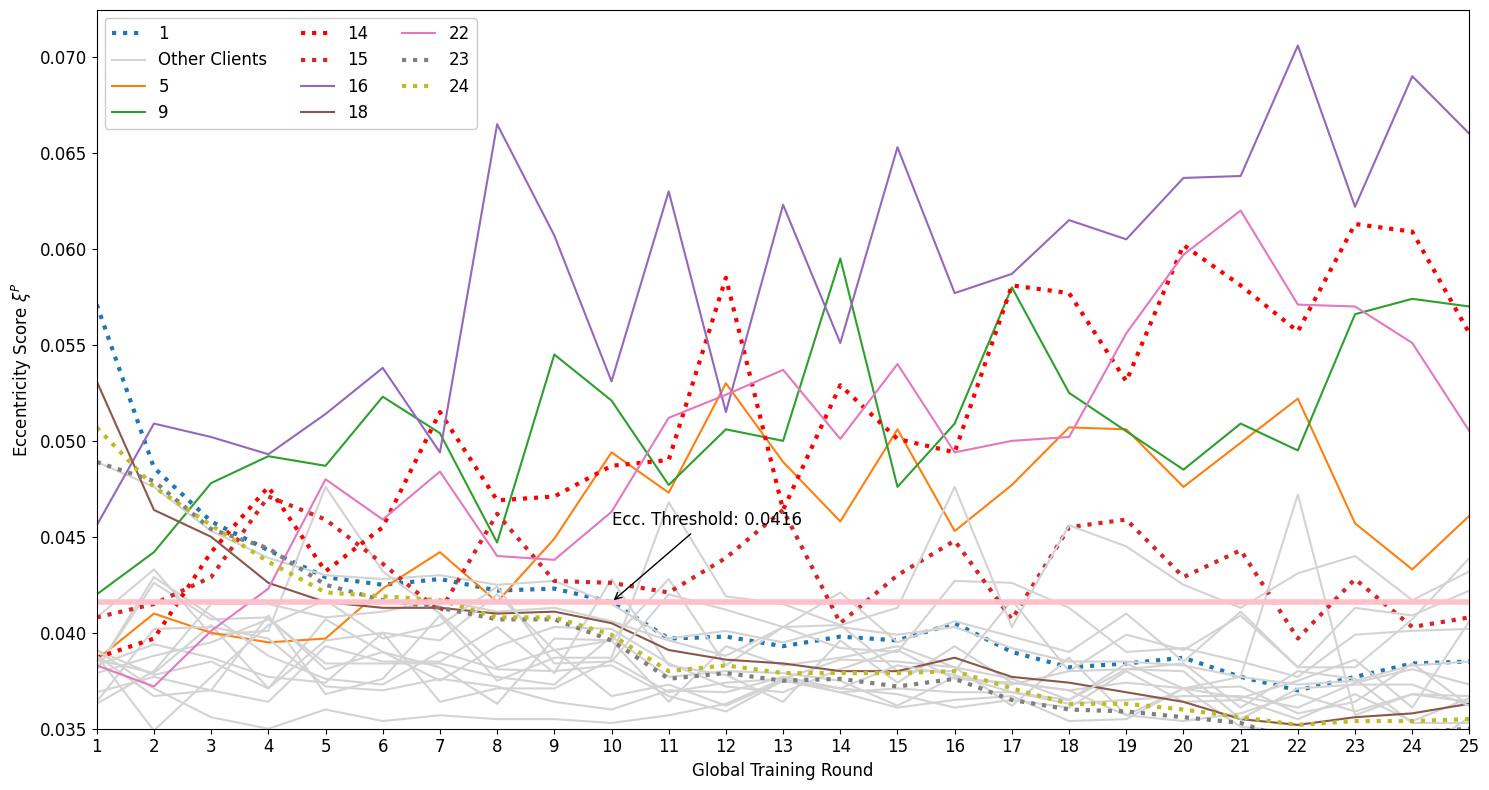

In [20]:
x_values = list(range(1, 26))

plt.figure(figsize=(15, 8))

for i, (key, values) in enumerate(ecc_dict.items()):
    if i+1 in [5,9,16,18,22]:
        plt.plot(x_values, values, label=str(i + 1))
    elif i+1 in [14]:
        plt.plot(x_values, values,color='red', label=str(i + 1), linestyle='dotted',linewidth=3)
    elif i+1 in [1,15,23,24]:
        plt.plot(x_values, values, label=str(i + 1), linestyle='dotted',linewidth=3)
    else:
        plt.plot(x_values, values, label='Other Clients', color='lightgray')
else:        
    plt.plot(x_values, [0.0416 for i in range(1, 26)], color='pink',linewidth=4)
    annotation_text = "Ecc. Threshold: 0.0416"  
    annotation_x = 10  
    annotation_y = 0.0416  
    plt.annotate(annotation_text, xy=(annotation_x, annotation_y), xytext=(annotation_x, annotation_y + 0.004),
                 arrowprops=dict(arrowstyle="->"),fontsize='large')

def legend_without_duplicate_labels(plt):
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    handles_unique, labels_unique = zip(*unique)
    plt.legend(handles_unique, labels_unique, ncol=3, bbox_to_anchor=(0,0,1,1), fontsize='large', framealpha=1)
    
plt.xlim(1,len(values))
plt.ylim(bottom=0.035)
plt.xlabel('Global Training Round', fontsize='large')
plt.ylabel('Eccentricity Score $\\xi^{P}$', fontsize='large')
legend_without_duplicate_labels(plt)
plt.xticks(x_values, fontsize='large')
plt.yticks(fontsize='large')
plt.tight_layout()
save_location = "../plots/ecc_param_signature.png"
plt.savefig(save_location)
plt.show()